‚úÖ Input Data Shape: (283585, 40)
‚úÖ Target Data Shape: (283585,)
üöÄ Training des Modells...

üìä Model Evaluation:
üîπ Mean Squared Error (MSE): 151043.48
üîπ Mean Absolute Error (MAE): 259.27
üîπ R¬≤ Score: 0.64

üî• Feature Importances:
gen_dispatchable_DE_TENNET       0.167690
load_DE_TENNET                   0.078022
load_DE_AMPRION                  0.042944
price_day_ahead_FR               0.041680
load_DE_TRANSNET                 0.040402
price_day_ahead_CH               0.040097
gen_run_off_hydro_DE_TENNET      0.038978
gen_dispatchable_DE_50HZ         0.034689
gen_run_off_hydro_DE_AMPRION     0.033050
gen_dispatchable_DE_AMPRION      0.032168
gen_wind_on_DE_50HZ              0.032072
gen_solar_DE_TENNET              0.029247
gen_wind_on_DE_TENNET            0.028764
gen_solar_DE_AMPRION             0.028647
price_day_ahead_DK_1             0.028637
gen_run_off_hydro_DE_TRANSNET    0.027884
gen_wind_total_DE_TENNET         0.022595
gen_wind_total_DE_50HZ           0.02

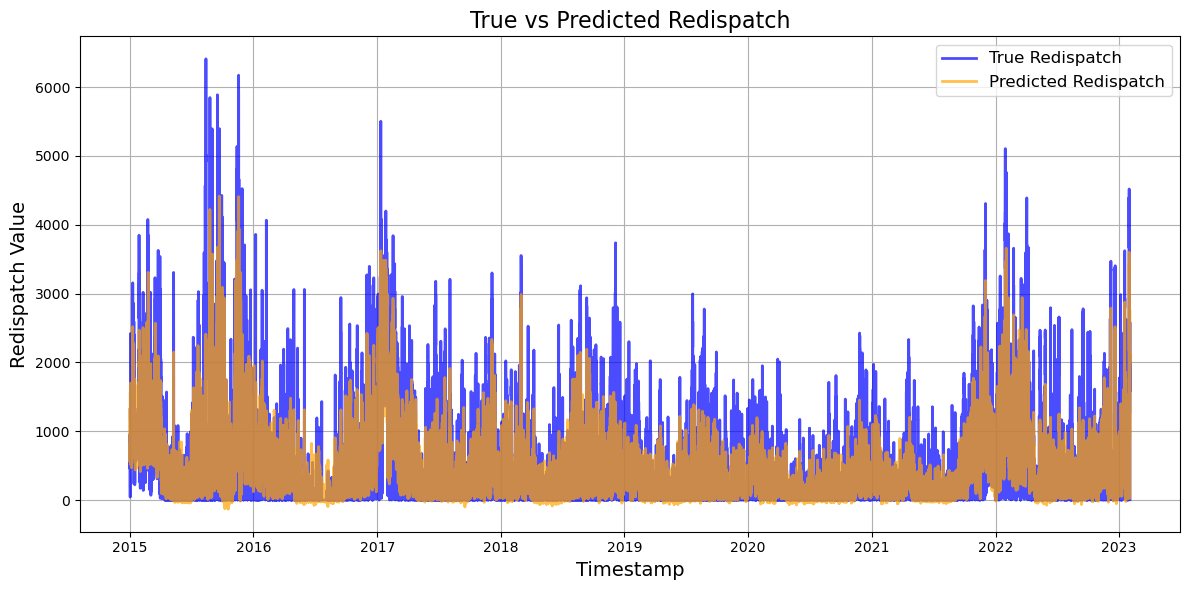

In [4]:
#XGBoost

import pickle
import pandas as pd
import os
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# üîπ Automatisch das aktuelle Verzeichnis bestimmen (Notebook oder Skript)
base_dir = Path().resolve()  # Ermittelt den aktuellen Arbeitsordner

# üîπ Datenpfade RELATIV zum Projektordner setzen
data_dir = base_dir / "data"

input_data_path = data_dir / "aligned_input_data.pkl"
target_data_path = data_dir / "aligned_target_data.pkl"

# üîπ Funktion zum Laden von Pickle-Dateien mit Fehlerbehandlung
def load_pickle(file_path):
    if not file_path.exists():
        raise FileNotFoundError(f"‚ùå Datei nicht gefunden: {file_path}")
    with open(file_path, "rb") as file:
        return pickle.load(file)

# ‚úÖ Lade Daten
input_data = load_pickle(input_data_path)
target_data = load_pickle(target_data_path)

# üîπ Sicherstellen, dass alle Spalten numerisch sind
input_data = input_data.apply(pd.to_numeric, errors="coerce")

# üîπ Entferne doppelte Spalten
input_data = input_data.loc[:, ~input_data.columns.duplicated()]

# üîπ Fehlende Werte behandeln
input_data = input_data.fillna(0)  # Ersetze NaN in input_data mit 0
target_data = target_data.fillna(target_data.mean())  # Ersetze NaN in target_data mit Durchschnitt

# üîπ Indizes von input_data und target_data angleichen
input_data, target_data = input_data.align(target_data, join="inner", axis=0)

# üîπ Form der Daten ausgeben
print(f"‚úÖ Input Data Shape: {input_data.shape}")
print(f"‚úÖ Target Data Shape: {target_data.shape}")

# üîπ XGBoost-Modell erstellen & trainieren
model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

print("üöÄ Training des Modells...")
model.fit(input_data, target_data)

# üîπ Modell evaluieren
predictions = model.predict(input_data)
mse = mean_squared_error(target_data, predictions)
mae = mean_absolute_error(target_data, predictions)
r2 = r2_score(target_data, predictions)

print("\nüìä Model Evaluation:")
print(f"üîπ Mean Squared Error (MSE): {mse:.2f}")
print(f"üîπ Mean Absolute Error (MAE): {mae:.2f}")
print(f"üîπ R¬≤ Score: {r2:.2f}")

# üîπ Feature Importance anzeigen
print("\nüî• Feature Importances:")
feature_importances = pd.Series(model.feature_importances_, index=input_data.columns)
print(feature_importances.sort_values(ascending=False))

# üîπ Visualisierung: Wahre vs. Vorhergesagte Werte
plt.figure(figsize=(12, 6))
plt.plot(target_data.index, target_data, label="True Redispatch", color="blue", alpha=0.7, linewidth=2)
plt.plot(target_data.index, predictions, label="Predicted Redispatch", color="orange", alpha=0.7, linewidth=2)

plt.title("True vs Predicted Redispatch", fontsize=16)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Redispatch Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


üöÄ Training des Modells...


100%|===================| 283553/283585 [68:51<00:00]        

üìä Erstelle SHAP-Plots...


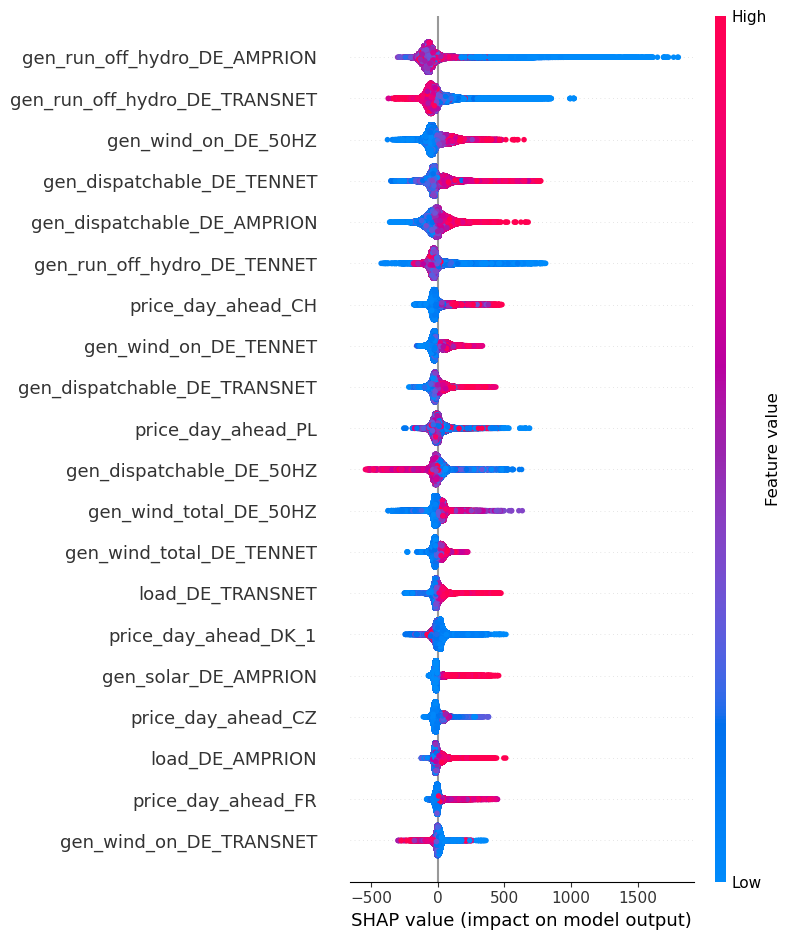

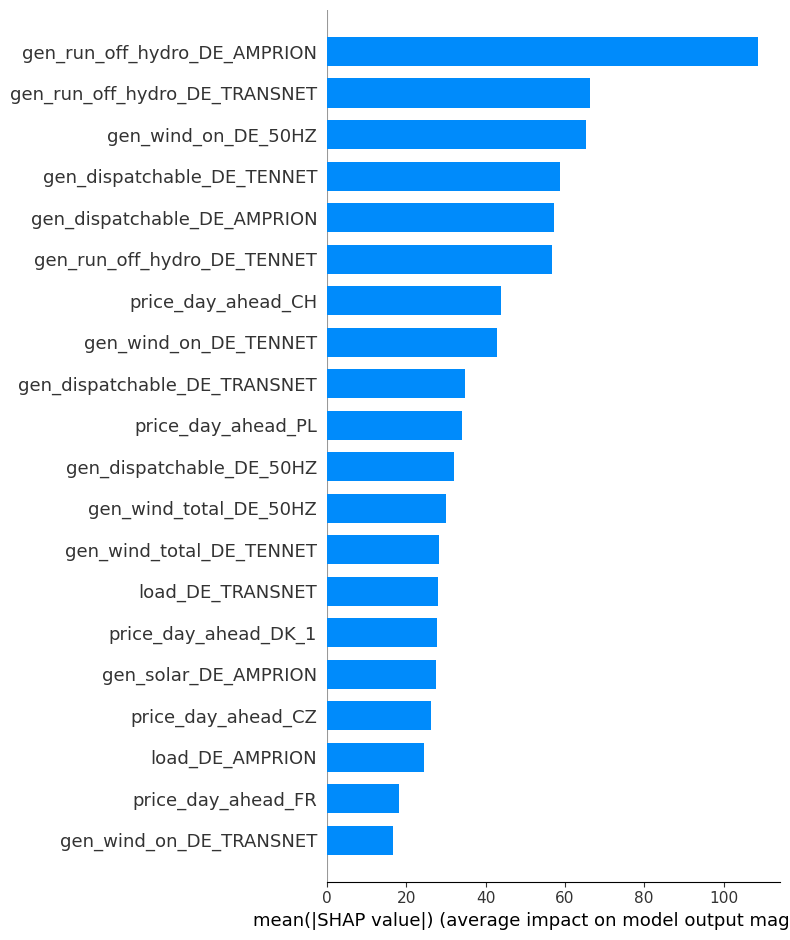

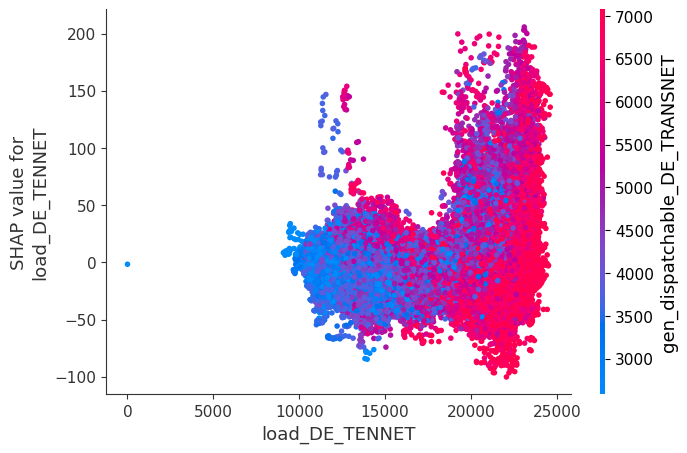

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [1]:
#SHAP


import shap
import xgboost as xgb
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

# üîπ Automatisch das aktuelle Arbeitsverzeichnis bestimmen
base_dir = Path().resolve()  # Ermittelt den aktuellen Ordner (Notebook oder Skript)

# üîπ Datenpfade relativ zum Projektordner setzen
data_dir = base_dir / "data"
input_data_path = data_dir / "aligned_input_data.pkl"
target_data_path = data_dir / "aligned_target_data.pkl"

# üîπ Funktion zum Laden von Pickle-Dateien mit Fehlerpr√ºfung
def load_pickle(file_path):
    if not file_path.exists():
        raise FileNotFoundError(f"‚ùå Datei nicht gefunden: {file_path}")
    with open(file_path, "rb") as file:
        return pd.read_pickle(file)

# ‚úÖ Lade Daten
input_data = load_pickle(input_data_path)
target_data = load_pickle(target_data_path)

# üîπ Fehlende Werte behandeln
input_data = input_data.fillna(0)
target_data = target_data.fillna(target_data.mean())

# üîπ Trainiere das XGBoost-Modell
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

print("üöÄ Training des Modells...")
model.fit(input_data, target_data)

# üîπ Erstelle SHAP-Explainer
explainer = shap.Explainer(model, input_data)

# üîπ Berechne SHAP-Werte
shap_values = explainer(input_data)

# üîπ SHAP Visualisierungen
print("üìä Erstelle SHAP-Plots...")

# 1Ô∏è‚É£ Summary Plot
shap.summary_plot(shap_values, input_data)

# 2Ô∏è‚É£ Bar Plot f√ºr Feature-Importance
shap.summary_plot(shap_values, input_data, plot_type="bar")

# 3Ô∏è‚É£ Dependence Plot f√ºr eine spezifische Feature-Spalte (falls vorhanden)
feature_name = "load_DE_TENNET"  # Anpassbar an deinen Datensatz
if feature_name in input_data.columns:
    shap.dependence_plot(feature_name, shap_values.values, input_data)

# 4Ô∏è‚É£ Force Plot f√ºr eine einzelne Instanz
shap.initjs()  # Aktiviert JS-Rendering in Jupyter Notebook
display(shap.force_plot(explainer.expected_value, shap_values[0, :], input_data.iloc[0, :]))

print("‚úÖ SHAP-Analyse abgeschlossen!")
